# Fetal-adult comparison
- fetal, gtex, PEC: shared permutation eGenes
- eQTL effect size: GTEx-fetal 247 pairs (removed variants with flipped ALT/REF) aFC and slope; PEC-fetal 253 pairs, slope (update: and aFC)

In [1]:
library(tidyverse)
library(data.table)
library(qvalue)
# library(RColorBrewer)
library(VennDiagram)
library(ggpubr)
library(ggsci)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘ggpubr’


The following object is masked from ‘package:VennDiagram’:

    rotate




### 1: Permutation eGene
- Note our data has TOPMed variants

In [5]:
fetal <- read.table("../results/mixed_perm_90hcp/all_assoc.txt.gz", header = T, stringsAsFactors = F)
# head(fetal)

In [8]:
dim(fetal)

[1] 31531    13

In [2]:
gtex <- fread("/u/project/gandalm/shared/GenomicDatasets/GTEx/GTEx_Analysis_v8_eQTL/Brain_Cortex.v8.egenes.txt.gz"
                   , data.table = F)
# head(gtex)

In [12]:
dim(gtex)

[1] 24849    33

In [3]:
gtex <- gtex %>% separate(gene_id, c("gene_ensg", "gene_version"), sep = "[.]", remove = FALSE)
length(unique(gtex$gene_id))
length(unique(gtex$gene_ensg))

[1] 24849

[1] 24849

In [4]:
sum(gtex$qval<0.05)

[1] 9082

In [6]:
pec <- fread("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_perm/PEC_geneQTL_perm_geneHCP100+gPCs20+AllMeta_assoc.txt.gz", 
                  data.table = F)
# head(pec)

In [7]:
dim(pec)

[1] 24762    20

In [8]:
fetal_sig <- fetal %>% filter(qval < 0.05)
gtex_sig <- gtex %>% filter(qval < 0.05)
pec_sig <- pec %>% filter(qval < 0.05)

In [12]:
length(unique(fetal_sig$pid)) #n1
length(unique(pec_sig$pid)) #n2
length(unique(gtex_sig$gene_ensg)) #n3

sum(unique(fetal_sig$pid) %in% unique(pec_sig$pid)) #n12
sum(unique(gtex_sig$gene_ensg) %in% unique(pec_sig$pid)) #n23
sum(unique(fetal_sig$pid) %in% unique(gtex_sig$gene_ensg)) #n13
length(Reduce(intersect, list(unique(fetal_sig$pid),
                              unique(gtex_sig$gene_ensg),
                              unique(pec_sig$pid)))) #n123

[1] 10094

[1] 16295

[1] 9082

[1] 7087

[1] 6979

[1] 4607

[1] 4088

png 
  2

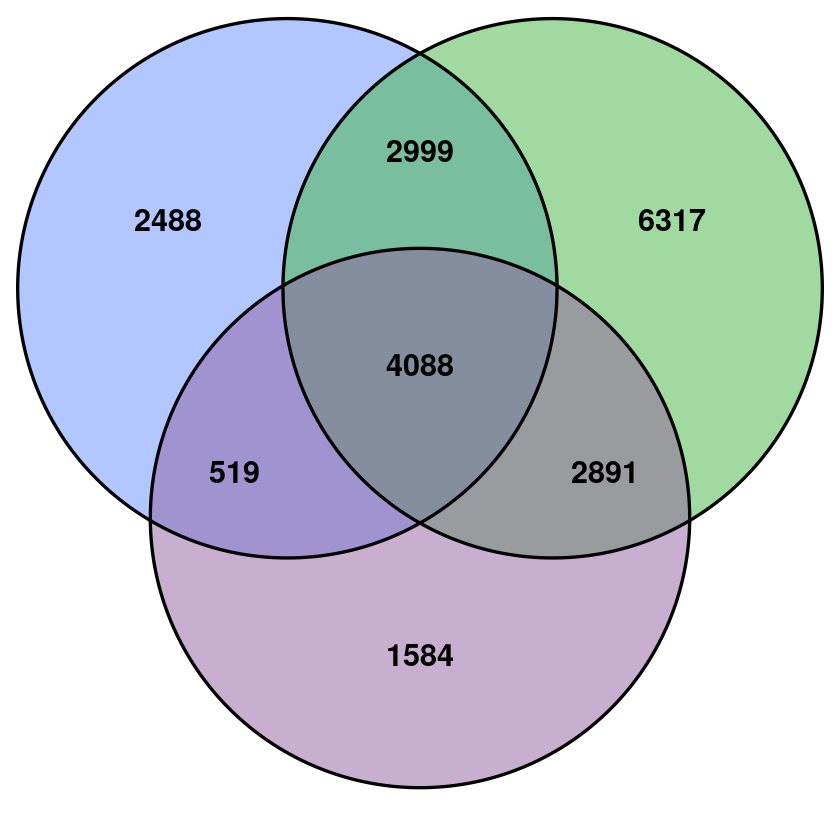

In [13]:
myCol <- c("#648FFF", "#42B540FF", "#925E9FFF")
# area1, area2, area3, n12, n23, n13, n123
venn.plot <- draw.triple.venn(10094, 16295, 9082, 7087, 6979, 4607, 4088, 
                              fill = myCol,
                              alpha = c(.5,.5,.5),
                              cex = 1.5,
                              fontface = 2,
                              fontfamily = rep("sans",7),
                              category = c("", "", ""), 
                              scaled = TRUE)
pdf("../figures/fetal_gtex_pec_perm_egene.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

### 2: eQTL effect size

`geom_smooth()` using formula 'y ~ x'



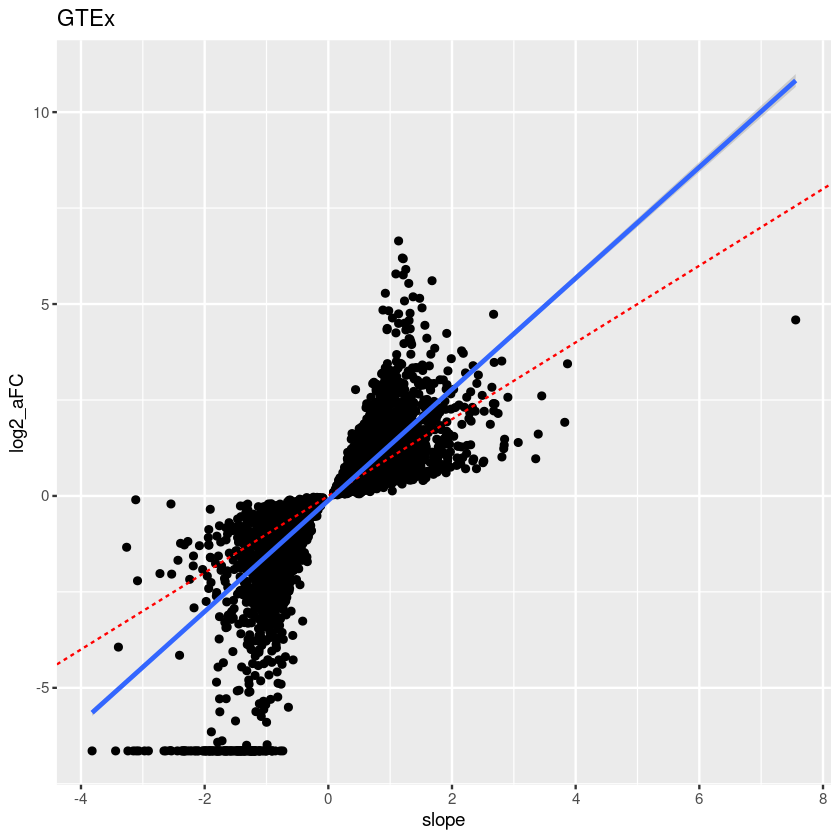

In [17]:
ggplot(gtex_sig, aes(x = slope, y = log2_aFC)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
    scale_x_continuous(breaks = seq(from = -4, to = 8, by = 2)) +
    geom_smooth(method = "lm") +
    ggtitle("GTEx")

In [5]:
fetal.afc <- fread("../results/mixed_perm_90hcp/aFC_boot100.txt", data.table = F)

In [6]:
pec.afc <- fread("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_perm/PEC_geneQTL_perm_geneHCP100+gPCs20+AllMeta_assoc/aFC_boot100.txt", data.table = F)

In [7]:
gtex_sig <- gtex_sig %>% 
    unite("gene_qtl", gene_ensg, rs_id_dbSNP151_GRCh38p7, sep = "-", remove = FALSE)
# head(gtex_sig)

In [8]:
fetal.afc <- fetal.afc %>%
    unite("gene_qtl", pid, sid, sep = "-", remove = FALSE)
# head(fetal.afc)

In [9]:
pec.afc.sig <- pec.afc %>% filter(qval < 0.05)
dim(pec.afc.sig)
length(unique(pec.afc.sig$pid))

[1] 16295    23

[1] 16295

In [10]:
pec.afc.sig <- pec.afc.sig %>% 
    separate(sid, c("pos", "id"), sep = ";") %>%
    unite("gene_qtl", pid, id, sep = "-")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 6 rows [5010, 5514, 12979, 13015, 13101, 13190].”


In [11]:
sum(gtex_sig$gene_qtl %in% fetal.afc$gene_qtl)
sum(pec.afc.sig$gene_qtl %in% fetal.afc$gene_qtl)

[1] 251

[1] 264

In [12]:
cols.num <- c("slope","log2_aFC", "log2_aFC_upper", "log2_aFC_lower")
fetal.afc[cols.num] <- sapply(fetal.afc[cols.num],as.numeric)

`geom_smooth()` using formula 'y ~ x'



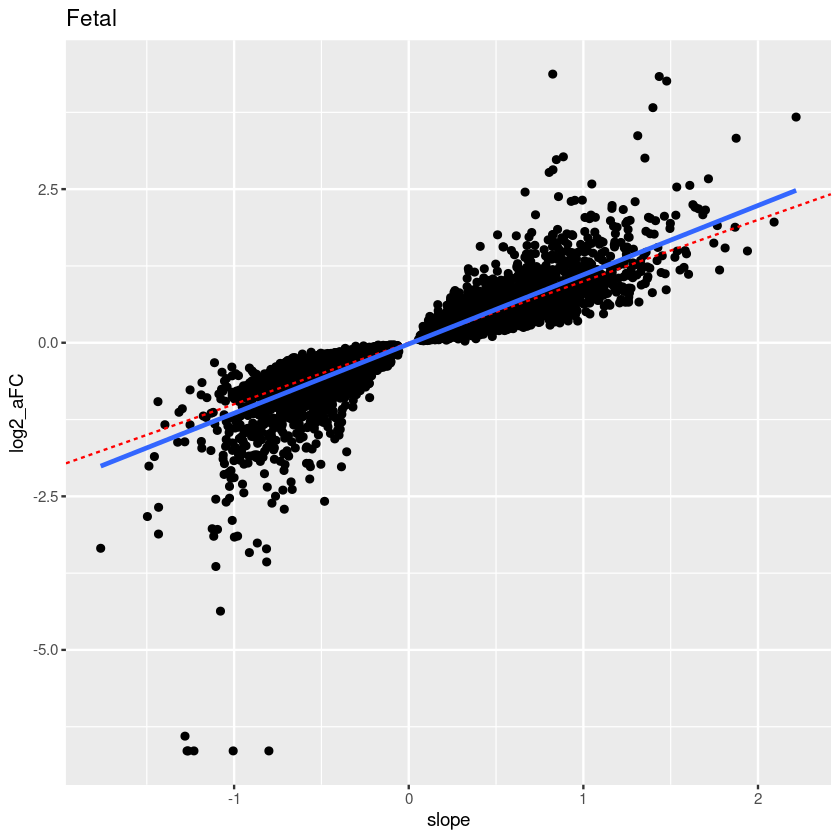

In [36]:
ggplot(fetal.afc, aes(x = slope, y = log2_aFC)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
    scale_x_continuous(breaks = seq(from = -4, to = 8, by = 1)) +
    geom_smooth(method = "lm") +
    ggtitle("Fetal")

In [13]:
shared <- fetal.afc %>% inner_join(gtex_sig, by = "gene_qtl")
dim(shared)

[1] 251  54

In [18]:
colnames(shared)

[1] "gene_qtl"                 "pid"                     
 [3] "nvar"                     "shape1"                  
 [5] "shape2"                   "dummy"                   
 [7] "sid"                      "dist"                    
 [9] "npval"                    "slope.x"                 
[11] "ppval"                    "bpval"                   
[13] "qval.x"                   "pval_nominal_threshold.x"
[15] "sid_chr"                  "sid_pos"                 
[17] "log2_aFC.x"               "log2_aFC_lower.x"        
[19] "log2_aFC_upper.x"         "gene_id"                 
[21] "gene_ensg"                "gene_version"            
[23] "gene_name"                "gene_chr"                
[25] "gene_start"               "gene_end"                
[27] "strand"                   "num_var"                 
[29] "beta_shape1"              "beta_shape2"             
[31] "true_df"                  "pval_true_df"            
[33] "variant_id"               "tss_distance"            
[35] "chr"                      "variant_pos"             
[37] "ref"                      "alt"                     
[39] "num_alt_per_site"         "rs_id_dbSNP151_GRCh38p7" 
[41] "minor_allele_samples"     "minor_allele_count"      
[43] "maf"                      "ref_factor"              
[45] "pval_nominal"             "slope.y"                 
[47] "slope_se"                 "pval_perm"               
[49] "pval_beta"                "qval.y"                  
[51] "pval_nominal_threshold.y" "log2_aFC.y"              
[53] "log2_aFC_lower.y"         "log2_aFC_upper.y"

In [14]:
shared1 <- fetal.afc %>% inner_join(pec.afc.sig, by = "gene_qtl")
dim(shared1)
colnames(shared1)

[1] 264  41

[1] "gene_qtl"               "pid"                    "nvar.x"                
 [4] "shape1.x"               "shape2.x"               "dummy.x"               
 [7] "sid"                    "dist.x"                 "npval.x"               
[10] "slope"                  "ppval.x"                "bpval.x"               
[13] "qval.x"                 "pval_nominal_threshold" "sid_chr"               
[16] "sid_pos"                "log2_aFC.x"             "log2_aFC_lower.x"      
[19] "log2_aFC_upper.x"       "chr"                    "start"                 
[22] "end"                    "strand"                 "nvar.y"                
[25] "dist.y"                 "pos"                    "var_chr"               
[28] "var_start"              "var_end"                "df"                    
[31] "dummy.y"                "shape1.y"               "shape2.y"              
[34] "npval.y"                "slopee"                 "ppval.y"               
[37] "bpval.y"                "qval.y"                 "log2_aFC.y"            
[40] "log2_aFC_lower.y"       "log2_aFC_upper.y"

**Remove variants with flipped ALT/REF**

In [15]:
fetal_bim <- fread("../../genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier.bim", data.table = F)
# head(fetal_bim)

In [16]:
shared <- shared %>% inner_join(fetal_bim, by = c("sid" = "V2")) %>% 
                 select(gene_qtl, log2_aFC.x, log2_aFC.y, slope.x, slope.y, V5, V6, ref, alt)
# head(shared)

In [21]:
shared %>% filter(V5 != alt)
shared %>% filter(V6 != ref)

gene_qtl,log2_aFC.x,log2_aFC.y,slope.x,slope.y,V5,V6,ref,alt
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ENSG00000030110-rs3216621,0.21615746,-0.269265,0.3065640,-0.568346,A,AG,A,AG
ENSG00000274070-rs34863951,-0.07955969,-0.535607,-0.1402250,-0.547243,G,A,T,C
ENSG00000266903-rs79638902,0.70686108,-2.632177,0.6165080,-1.236380,T,C,T,C
ENSG00000128266-rs3788337,-0.09038307,0.159811,-0.0803124,0.217843,A,G,A,G


gene_qtl,log2_aFC.x,log2_aFC.y,slope.x,slope.y,V5,V6,ref,alt
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ENSG00000030110-rs3216621,0.21615746,-0.269265,0.3065640,-0.568346,A,AG,A,AG
ENSG00000274070-rs34863951,-0.07955969,-0.535607,-0.1402250,-0.547243,G,A,T,C
ENSG00000266903-rs79638902,0.70686108,-2.632177,0.6165080,-1.236380,T,C,T,C
ENSG00000128266-rs3788337,-0.09038307,0.159811,-0.0803124,0.217843,A,G,A,G


In [17]:
shared <- shared %>% filter(!gene_qtl %in% c("ENSG00000030110-rs3216621", "ENSG00000274070-rs34863951", "ENSG00000266903-rs79638902", "ENSG00000128266-rs3788337"))

`geom_smooth()` using formula 'y ~ x'



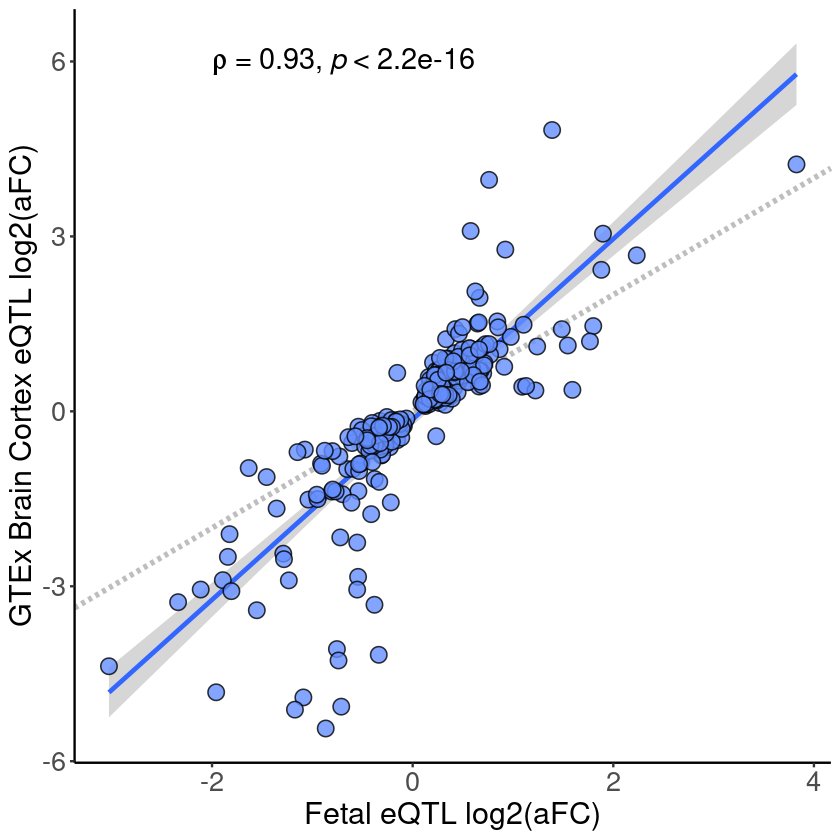

In [57]:
ggplot(shared, aes(x = log2_aFC.x, y = log2_aFC.y)) +
    geom_abline(intercept = 0, slope = 1, color = "grey", linetype = "dashed", size = 1.2) +
    geom_smooth(method = "lm") +
    geom_point(size = 4, fill = "#648FFF", shape = 21, alpha = 0.8) +
    labs(x = "Fetal eQTL log2(aFC)", y = "GTEx Brain Cortex eQTL log2(aFC)") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18)) +
    stat_cor(method = "spearman", label.x = -2, label.y = 6, cor.coef.name = "rho", size = 6)

In [28]:
# ggsave("../figures/fetal_gtex_aFC.pdf", width = 6, height = 6)

In [59]:
cor(shared$log2_aFC.x, shared$log2_aFC.y, method = "spearman")
cor(shared$slope.x, shared$slope.y, method = "spearman")

[1] 0.9279736

[1] 0.8981722

`geom_smooth()` using formula 'y ~ x'



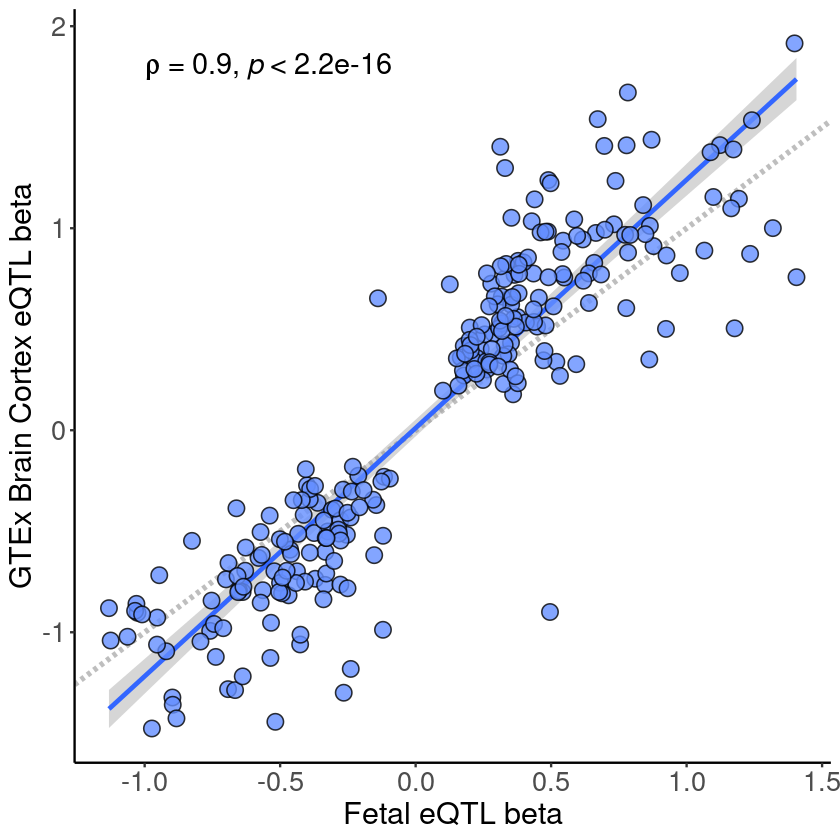

In [60]:
ggplot(shared, aes(x = slope.x, y = slope.y)) +
    geom_abline(intercept = 0, slope = 1, color = "grey", linetype = "dashed", size = 1.2) +
    geom_smooth(method = "lm") +
    geom_point(size = 4, fill = "#648FFF", shape = 21, alpha = 0.8) +
    labs(x = "Fetal eQTL beta", y = "GTEx Brain Cortex eQTL beta") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18)) +
    stat_cor(method = "spearman", label.x = -1, label.y = 1.8, cor.coef.name = "rho", size = 6)

In [29]:
# ggsave("../figures/fetal_gtex_beta.pdf", width = 6, height = 6)

In [18]:
pec_bim <- fread("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/Genotypes/PsychENCODE_rsid_1321/Capstone4.all_dbSNP_rsid_1321.bim", data.table = F)

In [19]:
shared1 <- shared1 %>% inner_join(fetal_bim, by = c("sid" = "V2")) %>% inner_join(pec_bim, by = c("sid" = "V2"))
# head(shared1)

In [20]:
dim(shared1)

[1] 264  51

In [48]:
colnames(shared1)

[1] "gene_qtl"               "pid"                    "nvar.x"                
 [4] "shape1.x"               "shape2.x"               "dummy.x"               
 [7] "sid"                    "dist.x"                 "npval.x"               
[10] "slope"                  "ppval.x"                "bpval.x"               
[13] "qval.x"                 "pval_nominal_threshold" "sid_chr"               
[16] "sid_pos"                "log2_aFC.x"             "log2_aFC_lower.x"      
[19] "log2_aFC_upper.x"       "chr"                    "start"                 
[22] "end"                    "strand"                 "nvar.y"                
[25] "dist.y"                 "pos"                    "var_chr"               
[28] "var_start"              "var_end"                "df"                    
[31] "dummy.y"                "shape1.y"               "shape2.y"              
[34] "npval.y"                "slopee"                 "ppval.y"               
[37] "bpval.y"                "qval.y"                 "log2_aFC.y"            
[40] "log2_aFC_lower.y"       "log2_aFC_upper.y"       "V1.x"                  
[43] "V3.x"                   "V4.x"                   "V5.x"                  
[46] "V6.x"                   "V1.y"                   "V3.y"                  
[49] "V4.y"                   "V5.y"                   "V6.y"

In [21]:
shared1 <- shared1 %>% select(gene_qtl, log2_aFC.x, log2_aFC.y, slope, slopee, V5.x, V6.x, V5.y, V6.y)
# head(shared1)

In [33]:
# shared1 %>% filter(V5.x != V5.y)
# shared1 %>% filter(V6.x != V6.y)

In [23]:
filpped <- shared1 %>% filter(V6.x != V6.y)
shared1 <- shared1 %>% filter(!gene_qtl %in% filpped$gene_qtl)
dim(shared1)

[1] 253   9

`geom_smooth()` using formula 'y ~ x'



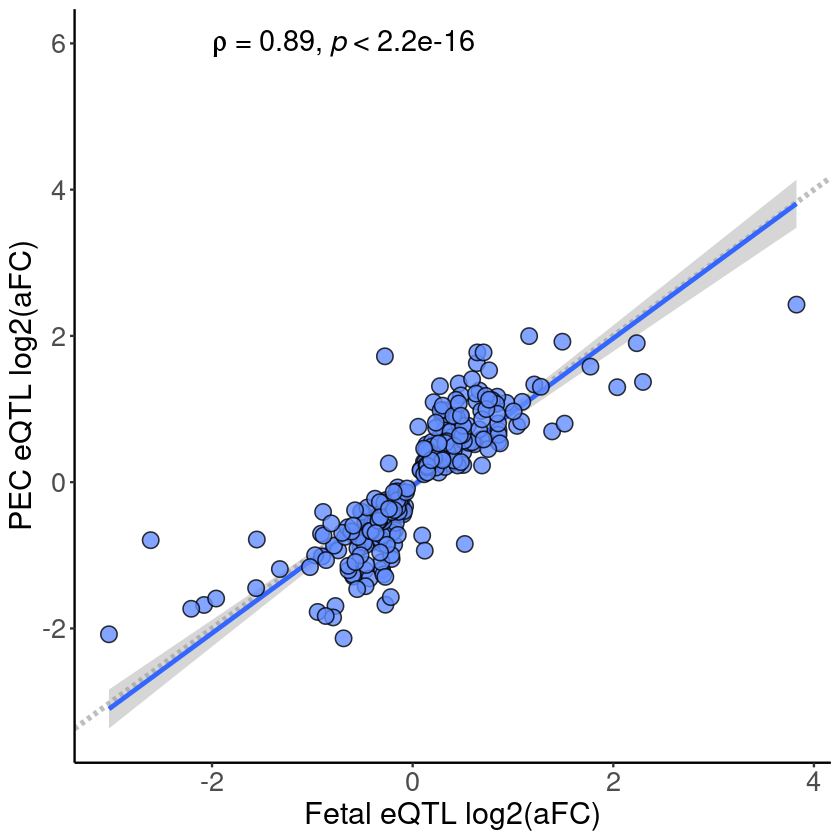

In [53]:
ggplot(shared1, aes(x = log2_aFC.x, y = log2_aFC.y)) +
    geom_abline(intercept = 0, slope = 1, color = "grey", linetype = "dashed", size = 1.2) +
    geom_smooth(method = "lm") +
    geom_point(size = 4, fill = "#648FFF", shape = 21, alpha = 0.8) +
    labs(x = "Fetal eQTL log2(aFC)", y = "PEC eQTL log2(aFC)") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18)) +
    stat_cor(method = "spearman", label.x = -2, label.y = 6, cor.coef.name = "rho", size = 6)

In [35]:
# ggsave("../figures/fetal_pec_aFC.pdf", width = 6, height = 6)

`geom_smooth()` using formula 'y ~ x'



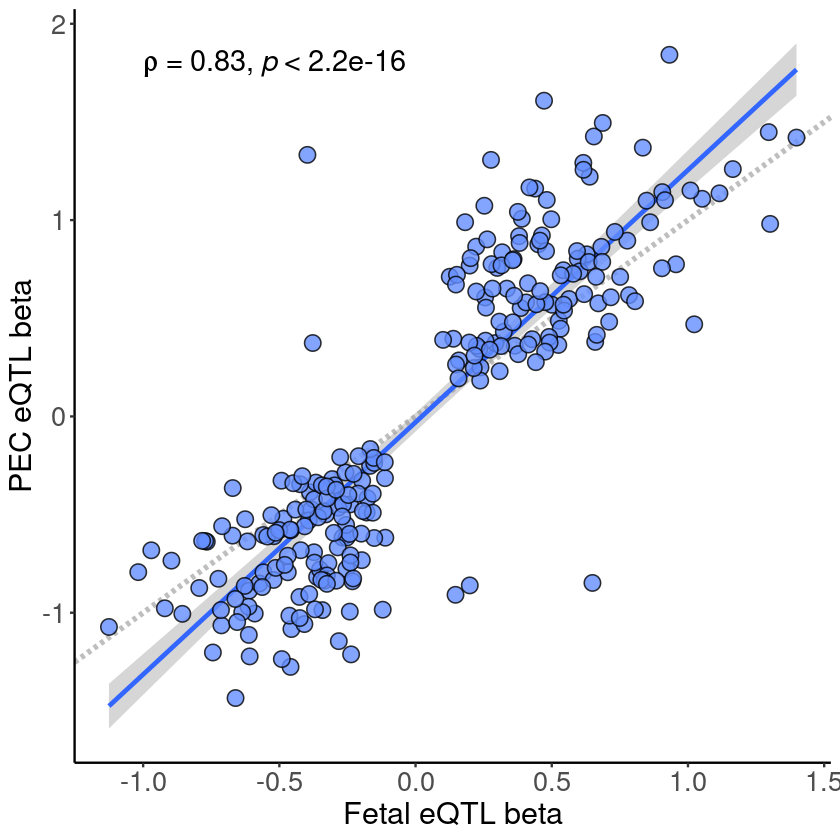

In [95]:
ggplot(shared, aes(x = slope, y = slopee)) +
    geom_abline(intercept = 0, slope = 1, color = "grey", linetype = "dashed", size = 1.2) +
    geom_smooth(method = "lm") +
    geom_point(size = 4, fill = "#648FFF", shape = 21, alpha = 0.8) +
    labs(x = "Fetal eQTL beta", y = "PEC eQTL beta") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18)) +
    stat_cor(method = "spearman", label.x = -1, label.y = 1.8, cor.coef.name = "rho", size = 6)

In [36]:
# ggsave("../figures/fetal_pec_beta.pdf", width = 6, height = 6)

In [24]:
dim(shared)
dim(shared1)

[1] 247   9

[1] 253   9

In [25]:
colnames(shared1) <- colnames(shared)
shared$Group <- "GTEx Brain Cortex"
shared1$Group <- "PsychENCODE"
df <- rbind(shared, shared1)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 30 rows containing missing values (`geom_smooth()`).”


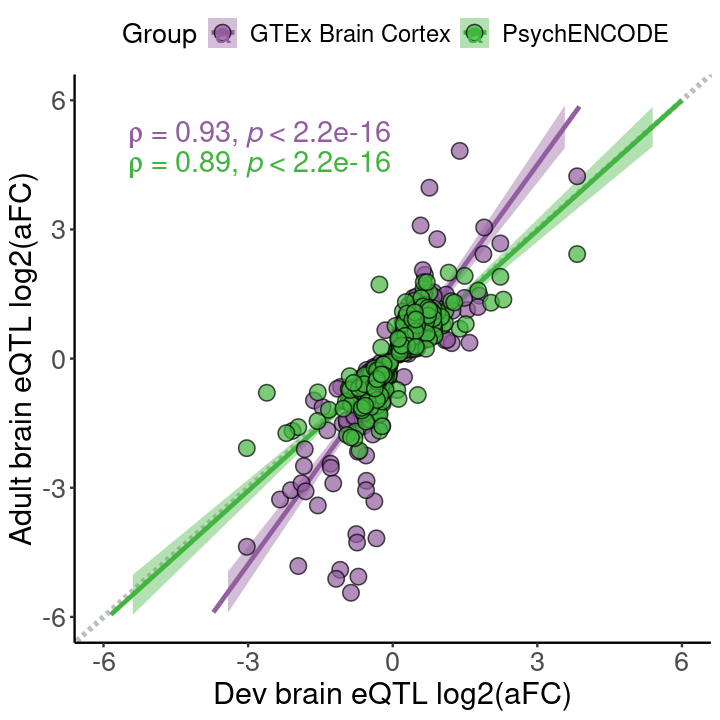

In [32]:
options(repr.plot.height = 6, repr.plot.width = 6)
myCol <- c("#925E9FFF", "#42B540FF")

ggplot(df, aes(x = log2_aFC.x, y = log2_aFC.y, fill = Group, color = Group)) +
    geom_abline(intercept = 0, slope = 1, color = "grey", linetype = "dashed", linewidth = 1.2) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    geom_point(size = 4, shape = 21, alpha = 0.7, color = "black") +
    labs(x = "Dev brain eQTL log2(aFC)", y = "Adult brain eQTL log2(aFC)") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "top") +
    stat_cor(data = shared, method = "spearman", label.x = -5.5, label.y = 5.2, cor.coef.name = "rho", size = 6) +
    stat_cor(data = shared1, method = "spearman", label.x = -5.5, label.y = 4.5, cor.coef.name = "rho", size = 6) +
    scale_fill_manual(values = myCol) +
    scale_color_manual(values = myCol) +
    scale_x_continuous(limits = c(-6, 6), breaks = seq(-6, 6, by = 3)) +
    scale_y_continuous(limits = c(-6, 6), breaks = seq(-6, 6, by = 3))

In [34]:
ggsave("../figures/fetal_gtex_pec_aFC.pdf", width = 6, height = 6)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 30 rows containing missing values (`geom_smooth()`).”


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 35 rows containing missing values (`geom_smooth()`).”


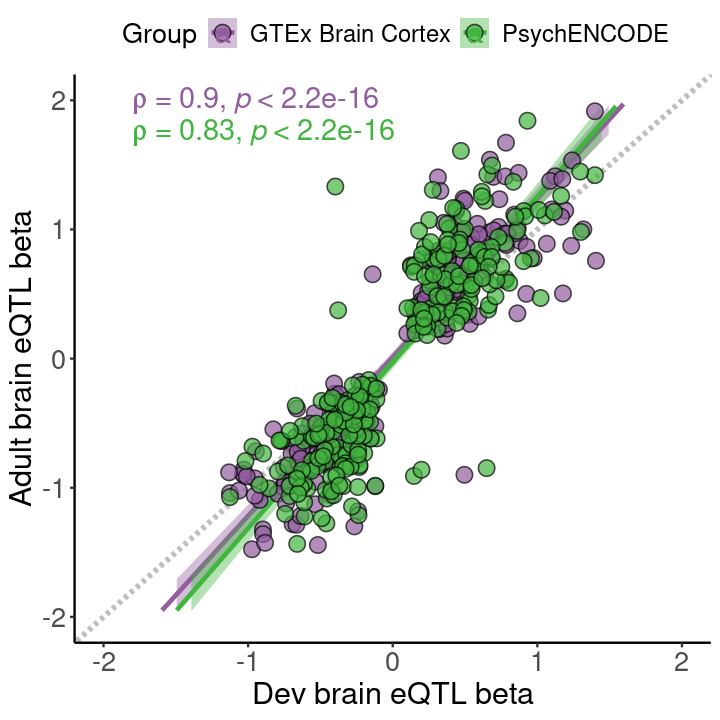

In [37]:
options(repr.plot.height = 6, repr.plot.width = 6)
myCol <- c("#925E9FFF", "#42B540FF")

ggplot(df, aes(x = slope.x, y = slope.y, fill = Group, color = Group)) +
    geom_abline(intercept = 0, slope = 1, color = "grey", linetype = "dashed", linewidth = 1.2) +
    geom_smooth(method = "lm", fullrange = TRUE) +
    geom_point(size = 4, shape = 21, alpha = 0.7, color = "black") +
    labs(x = "Dev brain eQTL beta", y = "Adult brain eQTL beta") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "top") +
    stat_cor(data = shared, method = "spearman", label.x = -1.8, label.y = 2, cor.coef.name = "rho", size = 6) +
    stat_cor(data = shared1, method = "spearman", label.x = -1.8, label.y = 1.75, cor.coef.name = "rho", size = 6) +
    scale_fill_manual(values = myCol) +
    scale_color_manual(values = myCol) +
    scale_x_continuous(limits = c(-2, 2), breaks = seq(-2, 2, by = 1)) +
    scale_y_continuous(limits = c(-2, 2), breaks = seq(-2, 2, by = 1))

In [39]:
ggsave("../figures/fetal_gtex_pec_beta.pdf", width = 6, height = 6)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 35 rows containing missing values (`geom_smooth()`).”


In [38]:
dim(shared) #gtex
dim(shared1) #pec

[1] 247  10

[1] 253  10